<a href="https://colab.research.google.com/github/M-Cavalcanti/MAQ_ROT/blob/main/MAQ_ROT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Versão 2

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Define Condition Labels, Folders, and Codes
Condition_label = [
    "Baseline",
    "Defeito Rolamento e Desbalanciamento",
    "Defeito Rolamento",
    "Desalinhamento Horiz Lado Oposto ao Acoplamento",
    "Desbalanciamento Lado do Acoplamento",
    "Desbalanciamento Lado Oposto ao Acoplamento"
]
Condition_folder = [
    "Baseline",
    "Defeito Rol e Desbalanc",
    "Defeito Rolamento",
    "DesalinhHorizLOA",
    "Desbalanc1LA",
    "Desbalanc2LOA"
]
Condition_code = [
    "Normal_",
    "RolamDesbal_",
    "Rolam_",
    "DesalinhHoriz_",
    "Desbalanc1_",
    "Desbalanc2_"
]

Machine_frequency = [10, 20, 30, 40]
Machine_frequency_label = [" 10 Hz", " 20 Hz", " 30 Hz", " 40 Hz"]
Machine_frequency_code = [label.replace(" ", "") for label in Machine_frequency_label]

# Function to Generate Filename
# N_freq is to be between 1 and 4, N_defect between 1 and 6, and N_series between 1 and 50
def file_path(N_freq, N_defect, N_series):
    return f'/content/drive/My Drive/Dados coletados/{Condition_folder[N_defect]}/{Machine_frequency_code[N_freq]}/{Condition_code[N_defect]}{Machine_frequency_code[N_freq]}_{(N_series+1):03d}.lvm'

In [ ]:
# Sampling parameters
Fs = 6e3  # Sampling frequency (Hz)
T = 1 / Fs  # Sampling period (seconds)
num_samples = int(35e3)  # Total number of samples

In [ ]:
import numpy as np
import pandas as pd

# Load data from a LVM file
def load_data(file_path):
    data = np.loadtxt(file_path, skiprows=23, max_rows=35000,encoding='latin-1')
    df = pd.DataFrame(data, columns=["X_Value", "Time", "Trigger", "Accel Coupled H", "Accel Coupled V", "Accel Uncoupled H", "Accel Uncoupled V", "Vel Coupled H", "Vel Coupled V", "Vel Uncoupled H", "Vel Uncoupled V"])
    return df


In [ ]:
# Step 1: Load all data into a list
data_list = []
labels = []

for freq in range(0, 4):  # Frequencies
    for defect in range(0, 6):  # Defects
        for timeseries in range(0, 50):  # Time series
            Filename = file_path(freq, defect, timeseries)
            data = load_data(Filename)  # Load data using your load_data function
            data_list.append(data)

            # Append the corresponding defect label to the labels list
            labels.append(defect)  # You can use the defect number as the label

In [ ]:
def transform_data(data, variable_pair, use_imag):
    # Extract the data for the selected variables
    if use_imag:
      var1 = data[variable_pair[0]]
      var2 = data[variable_pair[1]]

      # Create a complex signal
      complex_signal = 1 * var1 + 1j * var2
    else:
      # Extract the data for the selected variables
      complex_signal = data[variable_pair]

    return complex_signal

In [ ]:
# Step 2: Select a pair of variables for transformation and training
cond = 12
match  cond:
  case 1:
    selected_pair = ("Vel Uncoupled H", "Vel Uncoupled V")
    use_imag = True
  case 2:
    selected_pair = ("Vel Uncoupled H")
    use_imag = False
  case 3:
    selected_pair = ("Vel Uncoupled V")
    use_imag = False
  case 4:
    selected_pair = ("Accel Uncoupled H", "Accel Uncoupled V")
    use_imag = True
  case 5:
    selected_pair = ("Accel Uncoupled H")
    use_imag = False
  case 6:
    selected_pair = ("Accel Uncoupled V")
    use_imag = False
  case 7:
    selected_pair = ("Vel Coupled H", "Vel Coupled V")
    use_imag = True
  case 8:
    selected_pair = ("Vel Coupled H")
    use_imag = False
  case 9:
    selected_pair = ("Vel Coupled V")
    use_imag = False
  case 10:
    selected_pair = ("Accel Coupled H", "Accel Coupled V")
    use_imag = True
  case 11:
    selected_pair = ("Accel Coupled H")
    use_imag = False
  case 12:
    selected_pair = ("Accel Coupled V")
    use_imag = False


# Step 3: Apply the transformation to the selected variables
transformed_data_list = []

for data in data_list:
    complex_signal = transform_data(data, selected_pair,use_imag)
    transformed_data_list.append(complex_signal)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(transformed_data_list, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

from tensorflow.keras.utils import to_categorical
# y_train and y_test are in integer format, representing class indices
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

In [ ]:
# Define the MLP architecture
from keras.models import Sequential
from keras.layers import Dense, Input, concatenate
from keras.models import Model

num_classes = 6
num_epochs = 30
batch_size = 32

# Create complex input data by concatenating real and imaginary parts
if use_imag:
  X_train_complex = np.concatenate((X_train.real, X_train.imag), axis=1)
  X_test_complex = np.concatenate((X_test.real, X_test.imag), axis=1)
else:
  X_train_complex = X_train
  X_test_complex = X_test

# Input shape for complex data
input_shape = X_train_complex.shape[1:]

# Create the model
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_complex, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test_complex, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_complex, y_test)

print(f'Test accuracy: {test_acc}')S

Epoch 1/30
30/30 [==============================] - 4s 87ms/step - loss: 1.4083 - accuracy: 0.7458 - val_loss: 0.3630 - val_accuracy: 0.8875
Epoch 2/30
30/30 [==============================] - 2s 82ms/step - loss: 0.2245 - accuracy: 0.9802 - val_loss: 0.2895 - val_accuracy: 0.9500
Epoch 3/30
30/30 [==============================] - 3s 88ms/step - loss: 0.1327 - accuracy: 0.9969 - val_loss: 0.5453 - val_accuracy: 0.9375
Epoch 4/30
30/30 [==============================] - 3s 97ms/step - loss: 0.0598 - accuracy: 0.9979 - val_loss: 0.2667 - val_accuracy: 0.9375
Epoch 5/30
30/30 [==============================] - 2s 72ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.1790 - val_accuracy: 0.9542
Epoch 6/30
30/30 [==============================] - 2s 67ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.1704 - val_accuracy: 0.9583
Epoch 7/30
30/30 [==============================] - 2s 70ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.1640 - val_accuracy: 0.9583
Epoch 8/30
30

8/8 [==============================] - 0s 10ms/step


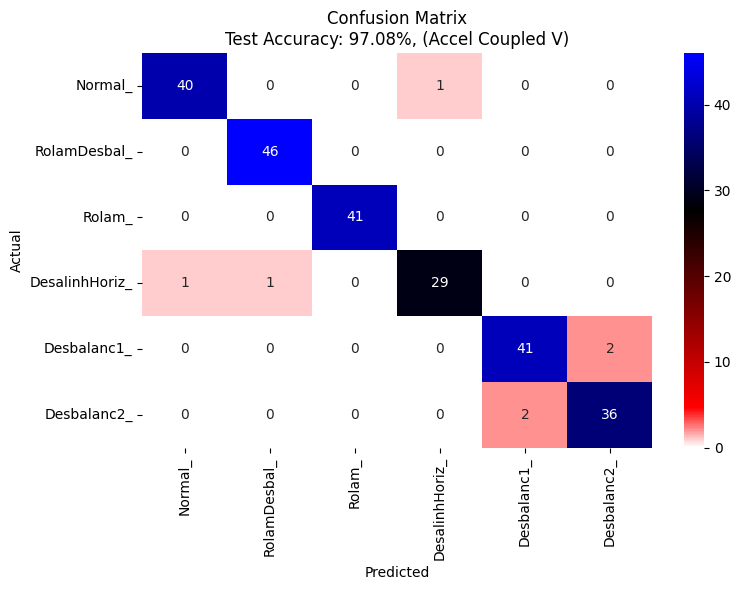

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

class_labels = Condition_code

# Make predictions on the test dataset
y_pred = model.predict(X_test_complex)
# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)


# Define the colors for the custom colormap
colors = [(0, 'white'),   # Low values are blue
          (0.1, 'red'),   # Transition color
          (0.6, 'black'), # Transition color
          (1, 'blue')]    # High values are red

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap=custom_cmap, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')

if use_imag:
  plt.title(f'Confusion Matrix\nTest Accuracy: {test_acc:.2%}, ({selected_pair[0]}_{selected_pair[1]})')
  filename = f'confusion_matrix_{selected_pair[0]}_{selected_pair[1]}.png'
else:
  filename = f'confusion_matrix_{selected_pair}.png'
  plt.title(f'Confusion Matrix\nTest Accuracy: {test_acc:.2%}, ({selected_pair})')


# Adjust layout to prevent cropping of labels
plt.tight_layout()
plt.savefig(filename)

plt.show()

In [ ]:
from google.colab import files
save = True
if save:
  !zip -r /content/HMPS.zip /content/HEATMAPS
  files.download("/content/HMPS.zip")

	zip warning: name not matched: /content/HEATMAPS

zip error: Nothing to do! (try: zip -r /content/HMPS.zip . -i /content/HEATMAPS)


FileNotFoundError: ignored